Exploration of RISE with image net (the author's own example model)

Function : Exploration of RISE with image net for first verification
Author : Team DIANNA
Contributor :
First Built : 2021.08.25
Last Update : 2021.08.25
Note : We ran the method using the image net model and various images from the internet. Results look as expected. Heatmaps make sense.

In [1]:
import os
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import pandas as pd
from dianna import visualization
from dianna.methods import RISE

In [2]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

In [3]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [4]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [5]:
model = Model()

C:\Users\ChristiaanMeijer\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


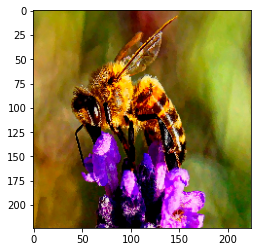

In [6]:
img, x = load_img('bee.jpg')
plt.imshow(img)

# Predict classes for test data

Print class and image of a single instance in the test data

In [7]:
sorted_classes = np.argsort(model.model.predict([x]))[0][::-1]
print('\n'.join(['{:4} {}'.format(c, class_name(c)) for c in sorted_classes]))

 309 bee
 946 cardoon
 308 fly
 319 dragonfly
  74 garden_spider
 321 admiral
 324 cabbage_butterfly
 318 lacewing
 815 spider_web
 323 monarch
 310 ant
  77 wolf_spider
 301 ladybug
 325 sulphur_butterfly
 322 ringlet
 311 grasshopper
 599 honeycomb
 944 artichoke
  73 barn_spider
 716 picket_fence
  76 tarantula
 320 damselfly
  94 hummingbird
 989 hip
 304 leaf_beetle
  70 harvestman
 303 long-horned_beetle
 315 mantis
 985 daisy
 326 lycaenid
 904 window_screen
 410 apiary
 995 earthstar
  72 black_and_gold_garden_spider
 312 cricket
  78 tick
 643 mask
 317 leafhopper
 984 rapeseed
 113 snail
 307 weevil
 313 walking_stick
 850 teddy
 990 buckeye
 314 cockroach
 125 hermit_crab
 696 paintbrush
  75 black_widow
 677 nail
 994 stinkhorn
 986 yellow_lady's_slipper
 998 ear
 219 cocker_spaniel
 316 cicada
 580 greenhouse
 950 orange
 782 screen
 396 lionfish
 973 coral_reef
 987 corn
 982 groom
 912 worm_fence
  11 goldfinch
 819 stage
 938 cauliflower
 991 coral_fungus
 958 hay
 428 

In [9]:
# investigate which value for p_keep works best by looking at the stddev of the probabilities for the target class,
best_class_id = sorted_classes[0]
def print_stats(p_keep):
    n_masks = 50
    feature_res = 8
    explainer = RISE(n_masks=n_masks, feature_res=feature_res, p_keep=p_keep)
    explainer.explain_image(model.run_on_batch, x)
    preds = explainer.predictions[:, best_class_id]
    df = pd.DataFrame(preds)
    display(df.describe())
    
print_stats(.5)  # stddev .15 is a bit low maybe, but min/max value of .16 and .93 seem fine

Explaining: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


,0
count,50.000000
mean,0.341694
std,0.215827
min,0.051071
25%,0.190701
50%,0.266859
75%,0.464024
max,0.819067


In [10]:
explainer = RISE(n_masks=2000, feature_res=8, p_keep=.5)
heatmaps = explainer.explain_image(model.run_on_batch, x)

Explaining: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.87s/it]


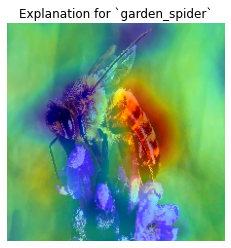

In [11]:
for current_class_id in sorted_classes[:5]:
    plt.title('Explanation for `{}`'.format(class_name(current_class_id)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(heatmaps[current_class_id], cmap='jet', alpha=0.5)
    plt.savefig('out2.png')

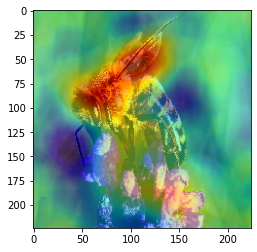

In [13]:
visualization.plot_image(heatmaps[best_class_id], image.img_to_array(img)/255., heatmap_cmap='jet')
# visualization.plot_image(heatmaps[class_idx], heatmap_cmap='gray')

# Conclusion
RISE higlights part of the bee, so it seems to work. Proper tuning of p_keep is important.

In [15]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[best_class_id])

shape: (224, 224) min: 0.2775405770407986 max: 0.36704502988133353 std: 0.014790578028119962


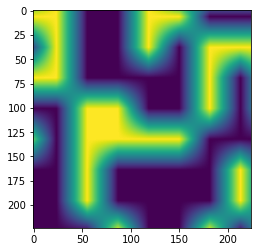

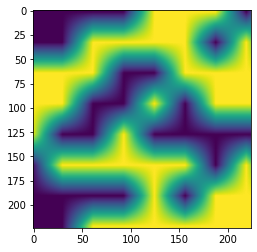

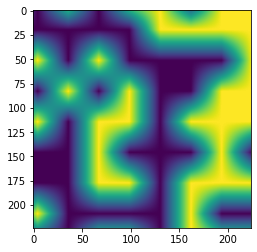

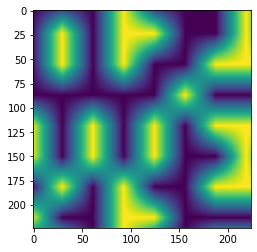

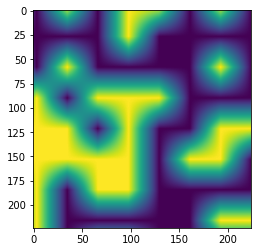

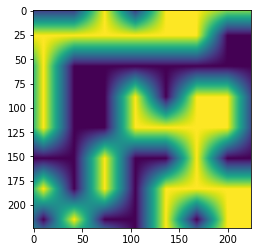

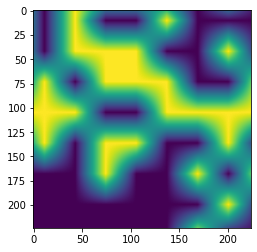

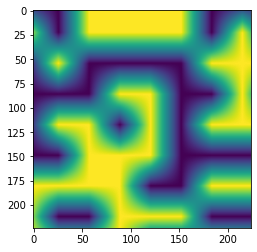

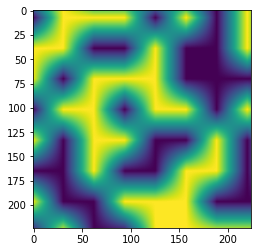

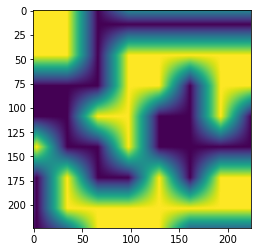

In [16]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()